# The Geographical Data Analysis

In [1]:
import folium
from bs4 import BeautifulSoup
import pandas as pd
import json, requests

In [2]:
data = requests.get("https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Bangalore").text
soup = BeautifulSoup(data, 'html.parser')
neighborhoodList = []
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
  neighborhoodList.append(row.text)
kl_df = pd.DataFrame({"Neighborhood": neighborhoodList})
kl_df.head(20)

,Neighborhood
0,List of areas in Bangalore Cantonment
1,List of areas in Bengaluru Pete
2,List of neighbourhoods in Bangalore
3,Adugodi
4,"Agara, Bangalore"
5,Ananthnagar
6,Anjanapura
7,Arekere
8,Austin Town
9,Babusapalya


In [3]:
kl_df = kl_df.drop([0,1,2])

In [4]:
kl_df.head()

,Neighborhood
3,Adugodi
4,"Agara, Bangalore"
5,Ananthnagar
6,Anjanapura
7,Arekere


In [5]:
kl_df = kl_df.reset_index()
kl_df.head()

,index,Neighborhood
0,3,Adugodi
1,4,"Agara, Bangalore"
2,5,Ananthnagar
3,6,Anjanapura
4,7,Arekere


In [6]:
kl_df.head()

,index,Neighborhood
0,3,Adugodi
1,4,"Agara, Bangalore"
2,5,Ananthnagar
3,6,Anjanapura
4,7,Arekere


In [7]:
import geocoder
def get_latlng(neighborhood):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Bangalore, India'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords
coords = [ get_latlng(neighborhood) for neighborhood in kl_df["Neighborhood"].tolist()]
coords

[[12.944010000000048, 77.60797000000008],
 [12.84292000000005, 77.48582000000005],
 [12.954080000000033, 77.54135000000008],
 [12.858110000000067, 77.55910000000006],
 [12.885670000000061, 77.59673000000004],
 [12.963480000000061, 77.61297000000008],
 [13.027180000000044, 77.65045000000003],
 [13.077263629807632, 77.65758952294048],
 [13.044710000000066, 77.55008000000004],
 [12.98929000000004, 77.65111000000007],
 [12.98929000000004, 77.65111000000007],
 [12.922310000000039, 77.56988000000007],
 [13.019526511351998, 77.65502797845224],
 [12.938980000000072, 77.57137000000006],
 [12.986740000000054, 77.54389000000003],
 [12.927340000000072, 77.67169000000007],
 [12.966180000000065, 77.58690000000007],
 [13.083010000000058, 77.54779000000008],
 [12.90008000000006, 77.60432000000003],
 [13.015990000000045, 77.61046000000005],
 [12.983991999946278, 77.6404896228702],
 [12.90307000000007, 77.62445000000008],
 [12.817510000000027, 77.67881000000006],
 [12.993330000000071, 77.66123000000005]

In [8]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
kl_df['Latitude'] = df_coords['Latitude']
kl_df['Longitude'] = df_coords['Longitude']
print(kl_df.shape)

(140, 4)


In [9]:
kl_df.head()

,index,Neighborhood,Latitude,Longitude
0,3,Adugodi,12.94401,77.60797
1,4,"Agara, Bangalore",12.84292,77.48582
2,5,Ananthnagar,12.95408,77.54135
3,6,Anjanapura,12.85811,77.55910
4,7,Arekere,12.88567,77.59673


In [10]:
kl_df = kl_df.drop(['index'],axis=1)
kl_df.head()

,Neighborhood,Latitude,Longitude
0,Adugodi,12.94401,77.60797
1,"Agara, Bangalore",12.84292,77.48582
2,Ananthnagar,12.95408,77.54135
3,Anjanapura,12.85811,77.55910
4,Arekere,12.88567,77.59673


In [11]:
kl_df.tail()

,Neighborhood,Latitude,Longitude
135,"Whitefield, Bangalore",12.97932,77.73370
136,Wilson Garden,12.94967,77.59675
137,Yelachenahalli,12.90044,77.56865
138,Yelahanka,13.09931,77.59259
139,Yeswanthpur,13.02954,77.54020


In [13]:
kl_df.shape

(140, 3)

In [14]:
map_kl = folium.Map(location=[12.9716,77.5946], zoom_start=11)
for lat, lng, neighborhood in zip(kl_df['Latitude'],  kl_df['Longitude'], kl_df['Neighborhood']):
 label = '{}'.format(neighborhood)
 label = folium.Popup(label, parse_html=True)
 folium.CircleMarker([lat, lng],radius=5,popup=label,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7).add_to(map_kl)
map_kl

# Exploring each neighborhood using Foursquare API

In [15]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180604'
radius = 2000
LIMIT = 100
venues = []
for lat, long, neighborhood in zip(kl_df['Latitude'], kl_df['Longitude'], kl_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,radius,LIMIT)
    results = requests.get(url).json()["response"]['groups'][0]['items']
    for venue in results:
        venues.append((neighborhood,lat,long,venue['venue']['name'],
        venue['venue']['location']['lat'],venue['venue']['location']    ['lng'],venue['venue']['categories'][0]['name']))

In [47]:
import json, requests
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id=CLIENT_ID,
client_secret=CLIENT_SECRET,
v='20180323',
ll='12.94401,77.60797',
radius = 2000,
limit=100
)
resp = requests.get(url=url, params=params)
data = json.loads(resp.text)

In [48]:
data

{'meta': {'code': 200, 'requestId': '6105452cc09b301a5ec72d4e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Koramangala',
  'headerFullLocation': 'Koramangala, Bangalore',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 155,
  'suggestedBounds': {'ne': {'lat': 12.962010018000019,
    'lng': 77.62640485006719},
   'sw': {'lat': 12.926009981999982, 'lng': 77.5895351499328}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c0e3245f319b7135c754b9a',
       'name': 'Tommy Hilfiger',
       'contact': {},
       'location': {'address': '#30, #31, #32, The Forum, #21, Hosur Road, 5th Block, Koramangala',
        'lat': 12.93455174548577,
        'lng': 77.6113470446

In [44]:
venues.append(data)

In [16]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
print(venues_df.shape)
venues_df.head()

(7503, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Adugodi,12.94401,77.60797,Tommy Hilfiger,12.934552,77.611347,Clothing Store
1,Adugodi,12.94401,77.60797,PVR IMAX,12.934595,77.611321,Movie Theater
2,Adugodi,12.94401,77.60797,Dyu Art Cafe,12.937289,77.617591,Financial or Legal Service
3,Adugodi,12.94401,77.60797,Truffles Ice & Spice,12.933443,77.614265,Burger Joint
4,Adugodi,12.94401,77.60797,Lot Like Crêpes,12.936421,77.613284,Creperie


In [18]:
venues_df

,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Adugodi,12.94401,77.60797,Tommy Hilfiger,12.934552,77.611347,Clothing Store
1,Adugodi,12.94401,77.60797,PVR IMAX,12.934595,77.611321,Movie Theater
2,Adugodi,12.94401,77.60797,Dyu Art Cafe,12.937289,77.617591,Financial or Legal Service
3,Adugodi,12.94401,77.60797,Truffles Ice & Spice,12.933443,77.614265,Burger Joint
4,Adugodi,12.94401,77.60797,Lot Like Crêpes,12.936421,77.613284,Creperie
...,...,...,...,...,...,...,...
7498,Yeswanthpur,13.02954,77.54020,Masala mantra,13.035397,77.533484,Indian Restaurant
7499,Yeswanthpur,13.02954,77.54020,Railway Crossing,13.038497,77.541977,Train Station
7500,Yeswanthpur,13.02954,77.54020,Metro Peenya Industry,13.036387,77.525567,Light Rail Station
7501,Yeswanthpur,13.02954,77.54020,Peenya Industrial Metro Station,13.036313,77.525475,Light Rail Station


In [19]:
venues_df.groupby(["Neighborhood"]).count().head()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Adugodi,100,100,100,100,100,100
Ananthnagar,25,25,25,25,25,25
Anjanapura,4,4,4,4,4,4
Arekere,78,78,78,78,78,78
Austin Town,100,100,100,100,100,100


In [20]:
print('There are {} unique categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 242 unique categories.


In [21]:
venues_df['VenueCategory'].unique()

array(['Clothing Store', 'Movie Theater', 'Financial or Legal Service',
       'Burger Joint', 'Creperie', 'Indian Restaurant', 'Breakfast Spot',
       'Brewery', 'Multiplex', 'Bar', 'Lounge', 'Dessert Shop', 'Café',
       'Tea Room', 'Juice Bar', 'Donut Shop', 'Shopping Mall',
       'Mobile Phone Shop', 'Ice Cream Shop', 'Chinese Restaurant',
       'Bakery', 'Gym', 'Gaming Cafe', 'Yoga Studio', 'Smoke Shop',
       "Men's Store", 'Indian Sweet Shop', 'Italian Restaurant',
       'Bookstore', 'Coffee Shop', 'Punjabi Restaurant',
       'Fast Food Restaurant', 'Andhra Restaurant', 'Mexican Restaurant',
       'Pizza Place', 'Bowling Alley', 'Kerala Restaurant',
       'Seafood Restaurant', 'Middle Eastern Restaurant',
       'Cosmetics Shop', 'Comfort Food Restaurant', 'Tibetan Restaurant',
       'Persian Restaurant', 'Thai Restaurant',
       'Paper / Office Supplies Store', 'Eastern European Restaurant',
       'Liquor Store', 'Sandwich Place', 'Restaurant', 'Snack Place',
      

In [22]:
kl_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")
kl_onehot['Neighborhoods'] = venues_df['Neighborhood']
fixed_columns = [kl_onehot.columns[-1]] + list(kl_onehot.columns[:-1])
kl_onehot = kl_onehot[fixed_columns]
print(kl_onehot.shape)

(7503, 243)


In [23]:
kl_onehot.head()

,Neighborhoods,ATM,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,...,Train Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Adugodi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adugodi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adugodi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adugodi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adugodi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
kl_grouped=kl_onehot.groupby(["Neighborhoods"]).sum().reset_index()
kl_grouped.head()

,Neighborhoods,ATM,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,...,Train Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Adugodi,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Ananthnagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Anjanapura,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arekere,0,0,0,0,1,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
4,Austin Town,0,0,0,0,1,1,1,0,0,...,0,0,0,0,2,0,0,0,0,0


In [25]:
len((kl_grouped[kl_grouped["Shopping Mall"] > 0]))

67

In [26]:
feature_dataset = kl_grouped[['Neighborhoods','Indian Restaurant','Fast Food Restaurant','South Indian Restaurant','Indian Chinese Restaurant','Gym','Fruit & Vegetable Store','Health Food Store','Playground','Athletics & Sports','Arcade','Bowling Alley']]
feature_dataset.head()

,Neighborhoods,Indian Restaurant,Fast Food Restaurant,South Indian Restaurant,Indian Chinese Restaurant,Gym,Fruit & Vegetable Store,Health Food Store,Playground,Athletics & Sports,Arcade,Bowling Alley
0,Adugodi,18,2,0,0,2,0,0,0,0,0,1
1,Ananthnagar,2,3,0,0,0,0,0,0,0,0,0
2,Anjanapura,0,0,0,0,0,0,0,0,0,0,0
3,Arekere,10,2,3,0,0,0,0,0,0,0,1
4,Austin Town,9,1,1,0,2,0,0,0,1,1,0


In [27]:
feature_dataset["Restaurants"] = feature_dataset["Indian Restaurant"]+feature_dataset["Fast Food Restaurant"]+feature_dataset["South Indian Restaurant"]+feature_dataset["Indian Chinese Restaurant"]

/home/aritra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
feature_dataset.head()

,Neighborhoods,Indian Restaurant,Fast Food Restaurant,South Indian Restaurant,Indian Chinese Restaurant,Gym,Fruit & Vegetable Store,Health Food Store,Playground,Athletics & Sports,Arcade,Bowling Alley,Restaurants
0,Adugodi,18,2,0,0,2,0,0,0,0,0,1,20
1,Ananthnagar,2,3,0,0,0,0,0,0,0,0,0,5
2,Anjanapura,0,0,0,0,0,0,0,0,0,0,0,0
3,Arekere,10,2,3,0,0,0,0,0,0,0,1,15
4,Austin Town,9,1,1,0,2,0,0,0,1,1,0,11


In [29]:
feature_dataset = feature_dataset.drop(["Indian Restaurant","Fast Food Restaurant","South Indian Restaurant","Indian Chinese Restaurant"],axis=1)
feature_dataset.head()

,Neighborhoods,Gym,Fruit & Vegetable Store,Health Food Store,Playground,Athletics & Sports,Arcade,Bowling Alley,Restaurants
0,Adugodi,2,0,0,0,0,0,1,20
1,Ananthnagar,0,0,0,0,0,0,0,5
2,Anjanapura,0,0,0,0,0,0,0,0
3,Arekere,0,0,0,0,0,0,1,15
4,Austin Town,2,0,0,0,1,1,0,11


In [30]:
feature_dataset["Sports"] = feature_dataset["Playground"]+feature_dataset['Athletics & Sports']+feature_dataset["Arcade"]+feature_dataset["Bowling Alley"]
feature_dataset.head()

,Neighborhoods,Gym,Fruit & Vegetable Store,Health Food Store,Playground,Athletics & Sports,Arcade,Bowling Alley,Restaurants,Sports
0,Adugodi,2,0,0,0,0,0,1,20,1
1,Ananthnagar,0,0,0,0,0,0,0,5,0
2,Anjanapura,0,0,0,0,0,0,0,0,0
3,Arekere,0,0,0,0,0,0,1,15,1
4,Austin Town,2,0,0,0,1,1,0,11,2


In [31]:
feature_dataset = feature_dataset.drop(['Playground','Athletics & Sports','Arcade','Bowling Alley'],axis=1)
feature_dataset.head()

,Neighborhoods,Gym,Fruit & Vegetable Store,Health Food Store,Restaurants,Sports
0,Adugodi,2,0,0,20,1
1,Ananthnagar,0,0,0,5,0
2,Anjanapura,0,0,0,0,0
3,Arekere,0,0,0,15,1
4,Austin Town,2,0,0,11,2


In [32]:
feature_dataset.shape

(139, 6)

In [33]:
from sklearn.cluster import KMeans
import numpy as np

In [34]:
from sklearn.preprocessing import StandardScaler
x = feature_dataset.values[:,1:]
x = np.nan_to_num(x)
x[:5]

array([[2, 0, 0, 20, 1],
       [0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 15, 1],
       [2, 0, 0, 11, 2]], dtype=object)

In [35]:
k_means = KMeans(init = "k-means++", n_clusters = 4)
labels = k_means.fit_predict(x)
labels

array([1, 0, 0, 2, 2, 3, 2, 0, 0, 2, 2, 3, 2, 3, 1, 1, 2, 0, 1, 0, 2, 2,
       0, 2, 0, 1, 0, 3, 0, 3, 0, 1, 1, 0, 2, 0, 1, 2, 2, 2, 1, 3, 3, 0,
       0, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 3, 1, 1,
       0, 0, 1, 3, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 1, 2, 1, 2, 0, 2,
       1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2,
       1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 1, 0, 2, 1, 0, 3, 2, 0, 0, 1, 0, 0,
       2, 0, 2, 2, 2, 0, 0], dtype=int32)

In [36]:
feature_dataset['Cluster_label'] = labels
feature_dataset.tail()

,Neighborhoods,Gym,Fruit & Vegetable Store,Health Food Store,Restaurants,Sports,Cluster_label
134,"Whitefield, Bangalore",1,0,0,11,1,2
135,Wilson Garden,0,0,1,9,1,2
136,Yelachenahalli,1,0,0,11,0,2
137,Yelahanka,0,0,0,3,0,0
138,Yeswanthpur,0,0,0,2,0,0


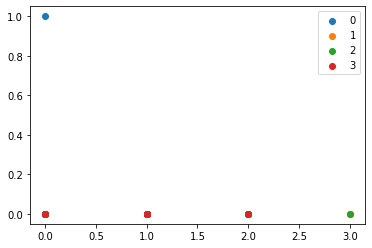

In [37]:
import matplotlib.pyplot as plt
for i in range(0,4):
    plt.scatter(x[labels == i,0],x[labels == i,1],label=i)
plt.legend()
plt.show()

In [38]:
kl_df.head()

,Neighborhood,Latitude,Longitude
0,Adugodi,12.94401,77.60797
1,"Agara, Bangalore",12.84292,77.48582
2,Ananthnagar,12.95408,77.54135
3,Anjanapura,12.85811,77.55910
4,Arekere,12.88567,77.59673


In [39]:
feature_dataset['Latitude'] = kl_df['Latitude']
feature_dataset['Longitude'] = kl_df['Longitude']
feature_dataset.head()

,Neighborhoods,Gym,Fruit & Vegetable Store,Health Food Store,Restaurants,Sports,Cluster_label,Latitude,Longitude
0,Adugodi,2,0,0,20,1,1,12.94401,77.60797
1,Ananthnagar,0,0,0,5,0,0,12.84292,77.48582
2,Anjanapura,0,0,0,0,0,0,12.95408,77.54135
3,Arekere,0,0,0,15,1,2,12.85811,77.55910
4,Austin Town,2,0,0,11,2,2,12.88567,77.59673


In [40]:
feature_dataset.sort_values(['Cluster_label'],inplace=True)
feature_dataset.head()

,Neighborhoods,Gym,Fruit & Vegetable Store,Health Food Store,Restaurants,Sports,Cluster_label,Latitude,Longitude
138,Yeswanthpur,0,0,0,2,0,0,13.09931,77.59259
75,Kodigehalli,0,0,0,3,1,0,12.90868,77.48718
96,Nandini Layout,0,0,0,7,3,0,12.95624,77.50936
95,Nagarbhavi,0,0,0,4,0,0,13.04103,77.55148
94,Muthyalanagar,0,0,0,8,0,0,12.95556,77.65333


In [41]:
feature_dataset.groupby("Cluster_label").mean()

,Gym,Fruit & Vegetable Store,Health Food Store,Restaurants,Sports,Latitude,Longitude
Cluster_label,,,,,,,
0,0.166667,0.016667,0.000000,3.633333,0.350000,12.971068,77.611147
1,1.233333,0.000000,0.000000,20.300000,0.600000,12.960769,77.600677
2,0.743590,0.000000,0.025641,12.923077,0.846154,12.966228,77.613199
3,0.800000,0.000000,0.000000,30.600000,0.700000,12.982031,77.593497


In [42]:
from matplotlib import cm,colors
map_clusters = folium.Map(location=[12.9716, 77.5946], zoom_start=11)
kclusters = 4
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(feature_dataset['Latitude'], feature_dataset['Longitude'], feature_dataset['Neighborhoods'], feature_dataset['Cluster_label']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat,lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
map_clusters

## View the complete build here:
https://clustering-predictor.herokuapp.com/